In [1]:
import os
import pandas as pd
import numpy as np
import random
from PIL import Image, ImageOps
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupKFold
import functools
from tqdm.notebook import tqdm

import torch
from torch.autograd import Variable
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# albumentation
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

In [2]:
# device
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

Set random seed

In [3]:
seed = 7
torch.manual_seed(seed) # cpu
np.random.seed(seed) #numpy
random.seed(seed) #random and transforms

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=True # cudnn

Prepare data for training

In [4]:
root = "/home/doriskao/project/super_resolution/data"

In [5]:
# freiburg data
freiburg_df = pd.read_json("./data/freiburg_data.json", orient="records")
freiburg_df['image'] = freiburg_df['image'].apply(lambda x: str(x).replace("\\", "/"))

gkf = GroupKFold(n_splits=5)
folds = list(gkf.split(freiburg_df['image'], freiburg_df['label'], freiburg_df['label']))
tid, vid = folds[0]

tfreiburg_imgs = freiburg_df['image'][tid]
vfreiburg_imgs = freiburg_df['image'][vid]

In [6]:
len(tfreiburg_imgs), len(vfreiburg_imgs)

(3964, 983)

In [7]:
# # celeba data
# celeba_data = "./data/img_align_celeba/img_align_celeba"
# celeba_images = os.listdir(celeba_data)
# celeba_images = list(map(lambda x: os.path.join("img_align_celeba", "img_align_celeba", x), celeba_images))

# train_idx, val_idx, _, _ = train_test_split(list(np.arange(len(celeba_images))), list(np.arange(len(celeba_images))), test_size=0.2, random_state=seed)

In [8]:
# tceleba_imgs = np.array(celeba_images)[train_idx]
# vceleba_imgs = np.array(celeba_images)[val_idx]

In [9]:
# len(tceleba_imgs), len(vceleba_imgs)

(162079, 40520)

In [10]:
# # shopee data
# shopee_df = pd.read_json("./data/shopee2020_data.json", orient="records")
# shopee_df['image'] = shopee_df['image'].apply(lambda x: str(x).replace("\\", "/"))
# shopee_df = shopee_df[shopee_df['valid_size']].reset_index(drop=True)

# tid, vid, _, _ = train_test_split(list(np.arange(len(shopee_df))), list(np.arange(len(shopee_df))), test_size=0.2, random_state=seed)

# tshopee_imgs = shopee_df['image'][tid]
# vshopee_imgs = shopee_df['image'][vid]

In [11]:
# len(tshopee_imgs), len(vshopee_imgs)

(84272, 21068)

In [7]:
# flicker (png)
flicker_df = pd.read_json("./data/flicker_data.json", orient="records")
flicker_df["left"] = flicker_df['image'].apply(lambda x: os.path.splitext(x)[0][-1] == "L")
flicker_df['image'] = flicker_df['image'].apply(lambda x: str(x).replace("\\", "/"))
flicker_df = flicker_df[flicker_df['left']].reset_index(drop=True)

tid, vid, _, _ = train_test_split(list(np.arange(len(flicker_df))), list(np.arange(len(flicker_df))), test_size=0.2, random_state=seed)

tflicker_imgs = flicker_df['image'][tid]
vflicker_imgs = flicker_df['image'][vid]

In [8]:
len(tflicker_imgs), len(vflicker_imgs)

(729, 183)

In [9]:
# div2k (png)
div2k_df = pd.read_json("./data/div2k_data.json", orient="records")
div2k_df['image'] = div2k_df['image'].apply(lambda x: str(x).replace("\\", "/"))

tid, vid, _, _ = train_test_split(list(np.arange(len(div2k_df))), list(np.arange(len(div2k_df))), test_size=0.2, random_state=seed)

tdiv2k_imgs = div2k_df['image'][tid]
vdiv2k_imgs = div2k_df['image'][vid]

In [10]:
len(tdiv2k_imgs), len(vdiv2k_imgs)

(720, 180)

In [11]:
# train_img = list(tfreiburg_imgs) + list(tshopee_imgs) #  + list(tceleba_imgs[:100000])
# val_img = list(vfreiburg_imgs) + list(vshopee_imgs) #  + list(vceleba_imgs[:20000])
train_imgs = list(tflicker_imgs) + list(tdiv2k_imgs) + list(tfreiburg_imgs)
val_imgs = list(vflicker_imgs) + list(vdiv2k_imgs) + list(vfreiburg_imgs)

In [12]:
# len(train_img), len(val_img)
len(train_imgs), len(val_imgs)

(5413, 1346)

In [14]:
# tid, _, _, _ = train_test_split(list(np.arange(len(train_img))), list(np.arange(len(train_img))), test_size=1-1000/len(train_img), random_state=seed)
# vid, _, _, _ = train_test_split(list(np.arange(len(val_img))), list(np.arange(len(val_img))), test_size=1-200/len(val_img), random_state=seed)

# train_imgs = np.array(train_img)[tid]
# val_imgs = np.array(val_img)[vid]

Create dataset

(1356, 2040, 3)


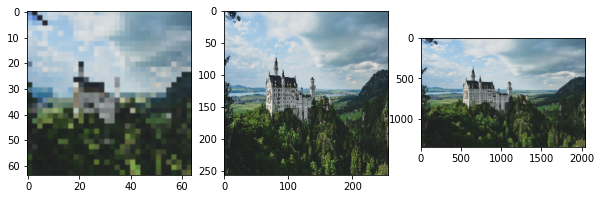

In [14]:
img = Image.open(os.path.join(root, list(train_imgs)[1019]))
img = img.convert("RGB") # size: w, h
img = np.array(img)
h, w, _ = img.shape
print(img.shape)

hr_img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LINEAR)
lr_img = cv2.GaussianBlur(img,(3, 3),cv2.BORDER_DEFAULT)
tmp = cv2.resize(lr_img, (32, 32), interpolation=cv2.INTER_NEAREST)
lr_img = cv2.resize(tmp, (64, 64), interpolation=cv2.INTER_NEAREST)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
ax1.imshow(lr_img)
ax2.imshow(hr_img)
ax3.imshow(img);

(256, 256, 3)
(256, 256, 3)
0.011172056198120117


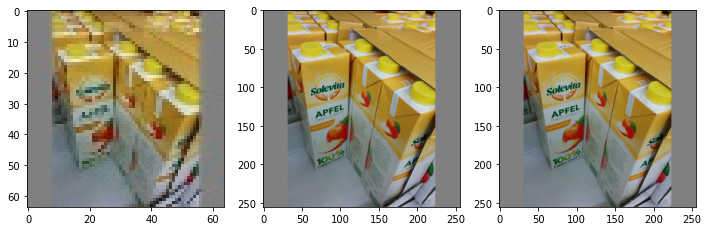

In [17]:
import time
st= time.time()
img = Image.open(os.path.join(root, list(train_imgs)[3319]))
img = img.convert("RGB")
img = np.array(img)

h, w, _ = img.shape
print(img.shape)

# if h>500 or w>500:
# #     nh, nw = int(h*0.7), int(w*0.7)
#     h, w = (h*500)//w, 500
#     img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)
nh, nw = 256, 256
sh = random.randint(0, h-nh)
sw = random.randint(0, w-nw)
crop_img = img[sh:(sh+nh), sw:(sw+nw)]
# crop_img = img[(h//2)-64:(h//2)+64, (w//2)-64:(w//2)+64]
# crop_img = img[(h//2)-128:(h//2)+128, (w//2)-128:(w//2)+128]
print(crop_img.shape)
# else:
#     crop_img = img.copy()

# hr_img = cv2.resize(crop_img, (128, 128), interpolation=cv2.INTER_LINEAR)
hr_img = crop_img
# enimg = cv2.imencode(".jpg", hr_img, [cv2.IMWRITE_JPEG_QUALITY, 95])[1]
# deimg = cv2.imdecode(enimg, 1)
lr_img = cv2.GaussianBlur(hr_img, (3, 3), cv2.BORDER_DEFAULT)
# tmp = cv2.resize(lr_img, (32, 32), interpolation=cv2.INTER_NEAREST)
lr_img = cv2.resize(lr_img, (64, 64), interpolation=cv2.INTER_NEAREST)
enimg = cv2.imencode(".jpg", lr_img, [cv2.IMWRITE_JPEG_QUALITY, 95])[1]
lr_img = cv2.imdecode(enimg, 1)
et = time.time()
print(et-st)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
# ax1.imshow(tmp);
ax1.imshow(lr_img)
ax2.imshow(hr_img)
ax3.imshow(img);

In [29]:
# # open image
# def load_images(root, img_list, hr_size=128, lr_size=64):
#     N = len(img_list)
#     hr_data = np.empty((N, hr_size, hr_size, 3), dtype=np.uint8)
#     lr_data = np.empty((N, lr_size, lr_size, 3), dtype=np.uint8)
#     for i, fpath in enumerate(img_list):
#         img = Image.open(os.path.join(root, fpath))
#         img = img.convert("RGB")
#         img = np.array(img)
        
#         hr_img = cv2.resize(img, (hr_size, hr_size), interpolation=cv2.INTER_LINEAR)
        
#         lr_img = cv2.GaussianBlur(img, (5, 5), cv2.BORDER_DEFAULT)
#         lr_img = cv2.resize(lr_img, (lr_size, lr_size), interpolation=cv2.INTER_NEAREST)
        
#         hr_data[i, ...] = hr_img
#         lr_data[i, ...] = lr_img
        
#     return hr_data, lr_data

In [17]:
# thr_imgs, tlr_imgs = load_images(root, img_list=train_imgs, hr_size=256, lr_size=128)
# vhr_imgs, vlr_imgs = load_images(root, img_list=val_imgs, hr_size=256, lr_size=128)

In [18]:
# class SRDataset(Dataset):
#     def __init__(self, hr_imgs, lr_imgs, transform=None):
#         super(SRDataset, self).__init__()
#         self.hr_imgs = hr_imgs
#         self.lr_imgs = lr_imgs
#         self.transform = transform
    
#     def __len__(self):
#         return self.hr_imgs.shape[0]
    
#     def __getitem__(self, idx):
#         hr_img = self.hr_imgs[idx, ...]
#         lr_img = self.lr_imgs[idx, ...]
        
#         if self.transform is not None:
#             hr_aug = self.transform(image=hr_img)
#             lr_aug = self.transform(image=lr_img)
#             hr_img = hr_aug['image']
#             lr_img = lr_aug['image']
        
#         return hr_img, lr_img

In [18]:
class SRDataset(Dataset):
    def __init__(self, root, img_list, hr_size=256, lr_size=64, transform=None, mode="train"):
        super(SRDataset, self).__init__()
        self.root = root
        self.img_list = img_list
        self.hr_size = hr_size
        self.lr_size = lr_size
        self.transform = transform
        self.mode = mode
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_list[idx])
        
        img = Image.open(img_path)
        img = img.convert("RGB")
        img = np.array(img)
        h, w, _ = img.shape
        nh, nw = self.hr_size, self.hr_size
        
#         if h>500 or w>500:
#             h, w = (h*500)//w, 500
#             img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)
            
        if self.mode == "valid":
            hr_img = img[(h//2)-nh//2:(h//2)+nh//2, (w//2)-nh//2:(w//2)+nh//2]
        else:
            sh = random.randint(0, h-nh)
            sw = random.randint(0, w-nw)
            hr_img = img[sh:(sh+nh), sw:(sw+nw)]
        
        # lower resolution image
        lr_img = cv2.GaussianBlur(hr_img, (3, 3), cv2.BORDER_DEFAULT)
#         tmp = cv2.resize(lr_img, (self.lr_size//2, self.lr_size//2), interpolation=cv2.INTER_NEAREST)
        lr_img = cv2.resize(lr_img, (self.lr_size, self.lr_size), interpolation=cv2.INTER_NEAREST)
        enimg = cv2.imencode(".jpg", lr_img, [cv2.IMWRITE_JPEG_QUALITY, 95])[1]
        lr_img = cv2.imdecode(enimg, 1)
        
        if self.transform is not None:
            hr_aug = self.transform(image=hr_img)
            lr_aug = self.transform(image=lr_img)
            hr_img = hr_aug['image']
            lr_img = lr_aug['image']
        
        return hr_img, lr_img

Data augmentation

In [19]:
transform = A.Compose([ToTensor(),])

In [20]:
batch_size = 16

train_dataset = SRDataset(root=root, img_list=train_imgs, hr_size=256, lr_size=64, transform=transform, mode="train")
# train_dataset = SRDataset(hr_imgs=thr_imgs, lr_imgs=tlr_imgs, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [21]:
val_dataset = SRDataset(root=root, img_list=val_imgs, hr_size=256, lr_size=64, transform=transform, mode="valid")
# val_dataset = SRDataset(hr_imgs=vhr_imgs, lr_imgs=vlr_imgs, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=8)

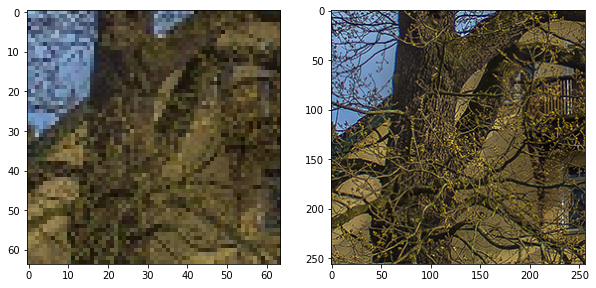

In [24]:
sr_img, lr_img = train_dataset[362]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(lr_img.permute(1, 2, 0).numpy())
ax2.imshow(sr_img.permute(1, 2, 0).numpy());

GAN  

                       real image ----> sample                         discriminator loss
                                               \                      /
                                                \                    /
                                                  -- discriminator --
                                                /                    \
                                               /                      \
    random input ----> generator  ----> sample                         generator loss

#### ESRGAN  
Perceptual quality is judged by `perceptual index`. A lower perceptual index represents a better perceptual quality.  

$\text{perceptual index} = \frac{1}{2}(10 - \text{MA} + \text{NIQE})$

#### Generator network
Remove batch normalization layer

In [25]:
# Generator network: generate the fake data
def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)

# Residual block
class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

    
# Residual in Residual dense block
class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x
    
# RRDB net
class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32):
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv3 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv4 = nn.Conv2d(nf+nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk

        fea1 = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea2 = self.lrelu(self.upconv2(F.interpolate(fea1, scale_factor=2, mode='nearest')))
        fea3 = self.lrelu(self.upconv3(fea2))
        fea4 = self.lrelu(self.upconv4(torch.cat((fea2, fea3), 1)))
        
        out = self.conv_last(self.lrelu(self.HRconv(fea4)))

        return out

#### Discriminator network
Using relativistic average GAN (RaGAN) ---> "whether one image is more realistic than the other"

In [26]:
# Discriminator network: distingrish between real and fake data
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,3,padding=1,bias=False)
#         self.conv2 = nn.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.conv2 = nn.Conv2d(64,64,2,stride=2,padding=0,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
#         self.bn2 = nn.GroupNorm(32, 64)
        self.conv3 = nn.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(128)
#         self.bn3 = nn.GroupNorm(32, 128)
        self.conv4 = nn.Conv2d(128,128,2,stride=2,padding=0,bias=False)
        self.bn4 = nn.BatchNorm2d(128)
#         self.bn4 = nn.GroupNorm(32, 128)
        self.conv5 = nn.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = nn.BatchNorm2d(256)
#         self.bn5 = nn.GroupNorm(32, 256)
        self.conv6 = nn.Conv2d(256,256,2,stride=2,padding=0,bias=False)
        self.bn6 = nn.BatchNorm2d(256)
#         self.bn6 = nn.GroupNorm(32, 256)
        self.conv7 = nn.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = nn.BatchNorm2d(512)
#         self.bn7 = nn.GroupNorm(32, 512)
        self.conv8 = nn.Conv2d(512,512,2,stride=2,padding=0,bias=False)
        self.bn8 = nn.BatchNorm2d(512)
#         self.bn8 = nn.GroupNorm(32, 512)
        self.fc1 = nn.Linear(512*16*16,1024)
#         self.fc1 = nn.Linear(512*8*8,1024)
        self.fc2 = nn.Linear(1024,1)
        self.drop = nn.Dropout2d(0.3)
        
    def forward(self, x):
        block1 = F.leaky_relu(self.conv1(x))
        block2 = F.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = F.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = F.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = F.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = F.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = F.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = F.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = F.leaky_relu(self.fc1(block8))
        block10 = self.fc2(block9)
#         block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block10

#### Feature extractor
Using VGG features before activation

In [27]:
# vgg feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self, backbone, pretrained=True):
        super(FeatureExtractor, self).__init__()
        self.backbone = backbone
        self.pretrained = pretrained
        self.cnn = self._extract_feature()
        
    def _extract_feature(self):
        cnn_backbone = getattr(models, self.backbone)(pretrained=self.pretrained)
        cnn_feature = cnn_backbone.features[0:8]
        return cnn_feature
    
    def forward(self, image):
        feature = self.cnn(image)
        
        return feature

model

In [28]:
# generator
pretrainedG = "./pretrained/RRDB_ESRGAN_x4.pth"
# pretrainedG = "./models/RRDB_ESRGAN_x2_1.pth"
modelG = RRDBNet(in_nc=3, out_nc=3, nf=64, nb=23, gc=32)
modelG.load_state_dict(torch.load(pretrainedG, map_location="cpu"), strict=False)
modelG = modelG.to(device)
modelG

RRDBNet(
  (conv_first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (RRDB_trunk): Sequential(
    (0): RRDB(
      (RDB1): ResidualDenseBlock_5C(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv5): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (RDB2): ResidualDenseBlock_5C(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), str

In [29]:
# discriminator
modelD = Discriminator()
modelD = modelD.to(device)
modelD

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(256, 512, kernel_size=(3, 

In [30]:
# model for extract feature
feature_model = FeatureExtractor("vgg19", pretrained=True)
feature_model = feature_model.to(device)
feature_model

FeatureExtractor(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

####  Define loss:  
- Generator loss  
- Discriminator loss
- Perceptual loss
- Contextual loss: "generate images with natural image statistics by using an objective that focuses on the feature distribution rather than merely comparing the appearance"

In [31]:
# discriminator loss
discriminator_loss = nn.BCEWithLogitsLoss()

# perceptual loss
perceptual_loss = nn.MSELoss()

# L1 loss (content loss)
L1_loss = nn.L1Loss()

In [32]:
def total_gen_loss(percep_loss, g_loss, l1_loss, lam=0.005, eeta=0.01):
    totalg_loss = percep_loss + lam * g_loss + eeta * l1_loss
    return totalg_loss

Optimizer: RMSProp, SGD

In [34]:
# optimizerG = optim.RMSprop(modelG.parameters(), lr=1e-4, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizerD = optim.RMSprop(modelD.parameters(), lr=1e-4, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

optimizerG = optim.Adam(modelG.parameters(), lr=3e-4, betas=(0.9, 0.999))
optimizerD = optim.Adam(modelD.parameters(), lr=3e-4, betas=(0.9, 0.999))

Scheduler

In [35]:
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=15, gamma=0.9, last_epoch=-1)
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=15, gamma=0.9, last_epoch=-1)

In [36]:
# plot learning rate
def plot_lr(optim, scheduler, epochs=80):
    lrs = []
    for i in range(epochs):
        optim.step()
        lrs.append(optim.param_groups[0]["lr"])
        scheduler.step()

    plt.plot(lrs)

In [32]:
# plot_lr(optimizerG, schedulerG, epochs=250)

Save model

In [37]:
def save_checkpoint(model, model_path, loss, best_loss, input_size=64, output_size=256):
    if loss < best_loss:
        print("saving model...")
        torch.save({'model_state_dict': model.state_dict(),
                    'loss': loss,
                    'input_size': input_size,
                    'output_size': output_size,
                   }, model_path)
        best_loss = loss
    return best_loss

In [38]:
# model_path = "./models/RRDB_ESRGAN_x4L.pth"
model_path = "./models/RRDB_ESRGAN_x4_png_l.pth"

Define training pipeline

In [39]:
class SaveLoss():
    def __init__(self):
        self.train_losses = dict()
        self.val_losses = dict()
        self.train_losses['disc_loss'] = []
        self.train_losses['discr_loss'] = []
        self.train_losses['discf_loss'] = []
        self.train_losses['generator_loss'] = []
        self.val_losses['disc_loss'] = []
        self.val_losses['discr_loss'] = []
        self.val_losses['discf_loss'] = []
        self.val_losses['generator_loss'] = []
        
    def _run(self, disc_loss, discr_loss, discf_loss, gen_loss, mode="train"):
        if mode == "train":
            self.train_losses['disc_loss'].append(disc_loss)
            self.train_losses['discr_loss'].append(discr_loss)
            self.train_losses['discf_loss'].append(discf_loss)
            self.train_losses['generator_loss'].append(gen_loss)
        elif mode == "valid":
            self.val_losses['disc_loss'].append(disc_loss)
            self.val_losses['discr_loss'].append(disc_loss)
            self.val_losses['discf_loss'].append(disc_loss)
            self.val_losses['generator_loss'].append(gen_loss)
        else:
            pass
        
    def get_loss(self):
        return self.train_losses, self.val_losses
    
    def __call__(self, disc_loss, discr_loss, discf_loss, gen_loss, mode="train"):
        self._run(disc_loss, discr_loss, discf_loss, gen_loss, mode)

In [ ]:
epochs = 200
accumulate_step = 1

losses = SaveLoss()

tdisc_l = []
tdiscr_l = []
tdiscf_l = []
tgen_l = []
vdisc_l = []
vdiscr_l = []
vdiscf_l = []
vgen_l = []
best_loss = 10000

for epoch in range(epochs):
    print(f"epoch {epoch+1}/{epochs}")
    optimizerG.zero_grad()
    optimizerD.zero_grad()
    
    # train
    modelD.train()
    modelG.train()
    feature_model.train()
    for i, (hrimgs, lrimgs) in enumerate(tqdm(train_dataloader)):
        hrimgs, lrimgs = hrimgs.to(device), lrimgs.to(device)

        # generator
        gen_hr = modelG(lrimgs)

        # discriminator
        discR = modelD(hrimgs)
        discF = modelD(gen_hr)

        # extract feature
        ghr_feature = feature_model(gen_hr)
        rhr_feature = feature_model(hrimgs)

        # discriminator loss
        discr_loss = discriminator_loss(discR - torch.mean(discF, 0, True), torch.ones_like(discR, dtype=torch.float))
        discf_loss = discriminator_loss(discF - torch.mean(discR, 0, True), torch.zeros_like(discF, dtype=torch.float))
        disc_loss = (discr_loss + discf_loss) / 2

        # total generator loss = perceptual loss + lambda * gen loss + eeta * l1_loss
        # perceptual loss
        percep_loss = perceptual_loss(ghr_feature, rhr_feature)
        # generator loss
        g_loss = discriminator_loss(discF - torch.mean(discR, 0, True), torch.ones_like(discF, dtype=torch.float))
        # l1 lsos
        l1_loss = L1_loss(gen_hr, hrimgs)
        # total generator loss
        totalg_loss = total_gen_loss(percep_loss, g_loss, l1_loss, lam=5e-3, eeta=1e-2)
        
        tdisc_l.append(disc_loss.item())
        tdiscr_l.append(discr_loss.item())
        tdiscf_l.append(discf_loss.item())
        tgen_l.append(totalg_loss.item())
        
        disc_loss.backward(retain_graph=True)
        totalg_loss.backward()
        
        if i % accumulate_step == 0 or i == len(train_dataloader):
            optimizerG.step()
            optimizerD.step()

            optimizerG.zero_grad()
            optimizerD.zero_grad()

    print(f"train ===> disc loss: {np.mean(tdisc_l)}  discr loss: {np.mean(tdiscr_l)}  discf loss: {np.mean(tdiscf_l)}  generator loss: {np.mean(tgen_l)}")
    # saving loss
    losses(np.mean(tdisc_l), np.mean(tdiscr_l), np.mean(tdiscf_l), np.mean(tgen_l), mode="train")
        
    # validate
    modelD.eval()
    modelG.eval()
    feature_model.eval()
    for hrimgs, lrimgs in tqdm(val_dataloader):
        hrimgs, lrimgs = hrimgs.to(device), lrimgs.to(device)
        
        with torch.no_grad():
            # generator
            gen_hr = modelG(lrimgs)

            # discriminator
            discR = modelD(hrimgs)
            discF = modelD(gen_hr)

            # extract feature
            ghr_feature = feature_model(gen_hr)
            rhr_feature = feature_model(hrimgs)
            
            # discriminator loss
            discr_loss = discriminator_loss(discR - torch.mean(discF, 0, True), torch.ones_like(discR, dtype=torch.float))
            discf_loss = discriminator_loss(discF - torch.mean(discR, 0, True), torch.zeros_like(discF, dtype=torch.float))
            disc_loss = (discr_loss + discf_loss) / 2
            
            # perceptual loss
            percep_loss = perceptual_loss(ghr_feature, rhr_feature)
            # generator loss
            g_loss = discriminator_loss(discF - torch.mean(discR, 0, True), torch.ones_like(discF, dtype=torch.float))
            # l1 lsos
            l1_loss = L1_loss(gen_hr, hrimgs)
            # total generator loss`
            totalg_loss = total_gen_loss(percep_loss, g_loss, l1_loss, lam=5e-3, eeta=1e-2)
            
            vdisc_l.append(disc_loss.item())
            vdiscr_l.append(discr_loss.item())
            vdiscf_l.append(discf_loss.item())
            vgen_l.append(totalg_loss.item())
            
    # saving loss
    losses(np.mean(vdisc_l), np.mean(vdiscr_l), np.mean(vdiscf_l), np.mean(vgen_l), mode="valid")
    
    # saving model
    best_loss = save_checkpoint(modelG, model_path, np.mean(vgen_l), best_loss, input_size=64, output_size=256)
    print(f"validate ===> disc loss: {np.mean(vdisc_l)}  discr loss: {np.mean(vdiscr_l)}  discf loss: {np.mean(vdiscf_l)}  generator loss: {np.mean(vgen_l)}")
    
    schedulerG.step()
    schedulerD.step()

epoch 1/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.02374876780478419  discr loss: 0.022622015260983345  discf loss: 0.02487552044215471  generator loss: 2.3709533622482883


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.02046903964022503  discr loss: 0.021490365995422884  discf loss: 0.019447713274070445  generator loss: 2.350847845918992
epoch 2/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.014495718940279895  discr loss: 0.013990222741385032  discf loss: 0.015001215187333227  generator loss: 2.172737208615362


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.018269007535213058  discr loss: 0.01923739792614737  discf loss: 0.017300617199062424  generator loss: 2.284324183183558
epoch 3/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.011358797762012221  discr loss: 0.011038568518652644  discf loss: 0.011679027042514096  generator loss: 2.0751501750805383


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.01942175632415741  discr loss: 0.02024546505006797  discf loss: 0.018598047642073796  generator loss: 2.2682461154227163
epoch 4/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.009793745673219298  discr loss: 0.009568710947351379  discf loss: 0.010018780426772234  generator loss: 2.01986500585677


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.01855006780447986  discr loss: 0.019292481318937942  discf loss: 0.01780765429002178  generator loss: 2.2393528719158735
epoch 5/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.008839686845034422  discr loss: 0.008665339700450032  discf loss: 0.009014034005585484  generator loss: 1.978204657335197


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.01824632073916933  discr loss: 0.018941134616513464  discf loss: 0.017551506813615562  generator loss: 2.219357550424688
epoch 6/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.008203219311038228  discr loss: 0.008061588092061357  discf loss: 0.008344850545152169  generator loss: 1.9461092167664886


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.01759256402888865  discr loss: 0.018203201089236957  discf loss: 0.01698192692836564  generator loss: 2.2050772500973124
epoch 7/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.007750000178206567  discr loss: 0.00763174287893661  discf loss: 0.007868257490156802  generator loss: 1.919922676008058


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.016846076482828674  discr loss: 0.017390561660266472  discf loss: 0.016301591266259675  generator loss: 2.1964297777464408
epoch 8/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.007408350319524821  discr loss: 0.007308076671150119  discf loss: 0.0075086239797674354  generator loss: 1.8962084394069196


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.016767073061782867  discr loss: 0.017250530249850057  discf loss: 0.016283615839475876  generator loss: 2.185945036043139
epoch 9/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.007141696964488693  discr loss: 0.007053518119933784  discf loss: 0.00722987581776135  generator loss: 1.8779479767876897


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.016504392543430228  discr loss: 0.0169405802080006  discf loss: 0.016068204848424476  generator loss: 2.1750553398350485
epoch 10/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006927915442140568  discr loss: 0.00684953919124004  discf loss: 0.007006291699650798  generator loss: 1.8590672752322701


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.016373417430612096  discr loss: 0.016770140073426507  discf loss: 0.015976694761501514  generator loss: 2.1667791031388677
epoch 11/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006753118871704059  discr loss: 0.0066823745443951735  discf loss: 0.006823863204522265  generator loss: 1.8435019570050402


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.016234742325635994  discr loss: 0.01660081270016371  discf loss: 0.01586867193417514  generator loss: 2.1599247802387582
epoch 12/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006607369949498689  discr loss: 0.006543713188904564  discf loss: 0.006671026716402185  generator loss: 1.828240356951102


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.01609686798206074  discr loss: 0.01643593442562383  discf loss: 0.015757801517497238  generator loss: 2.152820720508987
epoch 13/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006484360013106502  discr loss: 0.0064258661571769465  discf loss: 0.006542853874490269  generator loss: 1.8143325000088422


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.016071488253553125  discr loss: 0.016387021539488393  discf loss: 0.015755954962560898  generator loss: 2.1472380285888777
epoch 14/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.0063780451407339026  discr loss: 0.006324004211886841  discf loss: 0.0064320860730757235  generator loss: 1.8011584790306558


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.015848173124778295  discr loss: 0.016142959277216002  discf loss: 0.015553386967644847  generator loss: 2.1425618929522376
epoch 15/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006285740087007782  discr loss: 0.006235530806022516  discf loss: 0.006335949370980097  generator loss: 1.7893737450461824


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.0157222817630014  discr loss: 0.01599912937109669  discf loss: 0.015445434151253865  generator loss: 2.137723094482048
epoch 16/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.0062051169451314515  discr loss: 0.006158222302123044  discf loss: 0.006252011589995845  generator loss: 1.7773530798961454


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.015578642549499979  discr loss: 0.015839593973599703  discf loss: 0.015317691115128314  generator loss: 2.1344244995099655
epoch 17/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006135582799825363  discr loss: 0.00609245361934172  discf loss: 0.006178711981207397  generator loss: 1.7656358362237095


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.015398085728661515  discr loss: 0.015643552419726307  discf loss: 0.015152619028573526  generator loss: 2.131411287611331
epoch 18/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006072251382550417  discr loss: 0.006031657073861331  discf loss: 0.006112845692393234  generator loss: 1.7553447570831258


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.01524263523744261  discr loss: 0.015475237680282566  discf loss: 0.01501003278790687  generator loss: 2.128721978422863
epoch 19/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006015572890721496  discr loss: 0.005977249820429909  discf loss: 0.0060538959619615  generator loss: 1.745325031117278


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.015008153457010032  discr loss: 0.01522907530485246  discf loss: 0.01478723159878754  generator loss: 2.1254174055329784
epoch 20/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.007598198454772559  discr loss: 0.007892410053905018  discf loss: 0.0073039868079254645  generator loss: 1.743030141825873


  0%|          | 0/85 [00:00<?, ?it/s]

validate ===> disc loss: 0.014258621490582386  discr loss: 0.014467722283107052  discf loss: 0.014049520688193578  generator loss: 2.1278396276866687
epoch 21/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.00749000975227724  discr loss: 0.00782422034528244  discf loss: 0.007155799114346688  generator loss: 1.7339761249050194


  0%|          | 0/85 [00:00<?, ?it/s]

validate ===> disc loss: 0.013719885622012934  discr loss: 0.013896041575933245  discf loss: 0.013543729659578653  generator loss: 2.1258691470162208
epoch 22/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.0073813387883679025  discr loss: 0.0077114375465893925  discf loss: 0.007051239988824068  generator loss: 1.7253085313293435


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.013379649791642427  discr loss: 0.013540500082189386  discf loss: 0.013218799490602838  generator loss: 2.1237247071164176
epoch 23/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.007280103359305135  discr loss: 0.0076000078110614626  discf loss: 0.006960198868023086  generator loss: 1.7168275648559594


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.01318725502851617  discr loss: 0.013338356896915017  discf loss: 0.013036153145317095  generator loss: 2.122624804022367
epoch 24/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.0071863546392544105  discr loss: 0.007494433990249047  discf loss: 0.006878275249951698  generator loss: 1.709781360163215


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.013048990362629697  discr loss: 0.01319206754295725  discf loss: 0.012905913168575122  generator loss: 2.1213336900168773
epoch 25/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.00709969427376865  discr loss: 0.0073960633967748695  discf loss: 0.006803325115058111  generator loss: 1.7033839719415063


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.012973569506314748  discr loss: 0.01310952487739065  discf loss: 0.012837614126005332  generator loss: 2.1190645860503703
epoch 26/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.007020984902936843  discr loss: 0.007308614691723216  discf loss: 0.006733355080136385  generator loss: 1.6965154854042719


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.013126963661532699  discr loss: 0.013256007006656733  discf loss: 0.012997920313430066  generator loss: 2.1171353455042947
epoch 27/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006946535197773045  discr loss: 0.00722390150760982  discf loss: 0.00666916885576703  generator loss: 1.6895840455310196


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.01317159955626788  discr loss: 0.013294743217531307  discf loss: 0.013048455894976807  generator loss: 2.1152878225498988
epoch 28/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006877230492289905  discr loss: 0.007145074882099324  discf loss: 0.006609386071656381  generator loss: 1.6820801157163658


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.013290430224347985  discr loss: 0.013409003889473232  discf loss: 0.013171856559978705  generator loss: 2.1135598316413016
epoch 29/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006812808603654526  discr loss: 0.007071803859623635  discf loss: 0.006553813317782112  generator loss: 1.6754826984404547


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.013502854532038918  discr loss: 0.0136191978281581  discf loss: 0.01338651123287145  generator loss: 2.1125739973166895
epoch 30/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006752465730479435  discr loss: 0.00700313318960951  discf loss: 0.006501798242809135  generator loss: 1.668737148388766


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.013587187864320975  discr loss: 0.013699999907236063  discf loss: 0.013474375819554883  generator loss: 2.1115268597649592
epoch 31/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006696144858345861  discr loss: 0.006939146790221703  discf loss: 0.006453142899470796  generator loss: 1.6621302207276965


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.013774782580795364  discr loss: 0.013884477626754448  discf loss: 0.013665087537286305  generator loss: 2.1106130473075373
epoch 32/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006643153682717617  discr loss: 0.006878781594396815  discf loss: 0.006407525745312182  generator loss: 1.6555211238870755


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.01393392323830973  discr loss: 0.014040837180611896  discf loss: 0.013827009295641842  generator loss: 2.110458636152394
epoch 33/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006593259102084635  discr loss: 0.006821966718179688  discf loss: 0.006364551461708931  generator loss: 1.6493101382453756


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.013953175122535882  discr loss: 0.014057848437003114  discf loss: 0.013848501807381989  generator loss: 2.1093758886510674
epoch 34/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006546515346162231  discr loss: 0.00676927294611104  discf loss: 0.006323757722525705  generator loss: 1.6429469689620817


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.014109152662193977  discr loss: 0.01421118954816868  discf loss: 0.014007115775552808  generator loss: 2.108545998099766
epoch 35/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.0065023945492468215  discr loss: 0.006719172321908016  discf loss: 0.006285616754241896  generator loss: 1.6372268520374114


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.014159344858666805  discr loss: 0.014258518781997727  discf loss: 0.014060170935627607  generator loss: 2.107987603179547
epoch 36/200


  0%|          | 0/339 [00:00<?, ?it/s]

train ===> disc loss: 0.006460549342879107  discr loss: 0.006671714140695676  discf loss: 0.006249384523568404  generator loss: 1.6315829561298614


  0%|          | 0/85 [00:00<?, ?it/s]

saving model...
validate ===> disc loss: 0.014278020630070174  discr loss: 0.014374724255852985  discf loss: 0.014181317008223228  generator loss: 2.1072149820577084
epoch 37/200


  0%|          | 0/339 [00:00<?, ?it/s]

In [ ]:
import json
train_loss, val_loss = losses.get_loss()
with open("./train_loss.json",'w') as f:
    json.dump(train_loss, f)
    
with open("./val_loss.json",'w') as f:
    json.dump(val_loss, f)

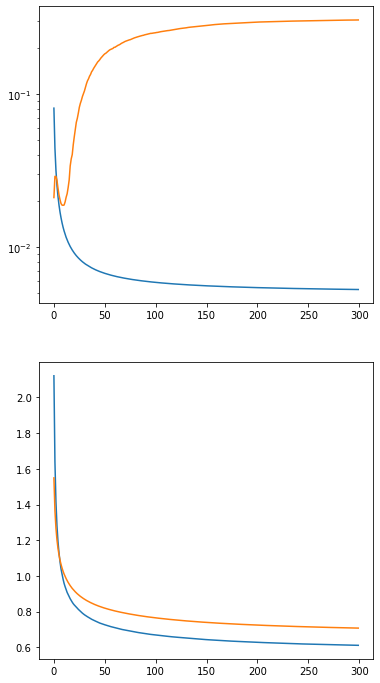

In [49]:
train_loss, val_loss = losses.get_loss()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))
ax1.plot(np.arange(len(train_loss["disc_loss"])), train_loss["disc_loss"])
ax1.plot(np.arange(len(val_loss["disc_loss"])), val_loss["disc_loss"])
ax1.set_yscale("log");

ax2.plot(np.arange(len(train_loss["generator_loss"])), train_loss["generator_loss"])
ax2.plot(np.arange(len(val_loss["generator_loss"])), val_loss["generator_loss"]);

#### Test images

Load model

In [50]:
Genmodel_path = "./models/RRDB_ESRGAN_x2_q95.pth"
Genmodel = RRDBNet(in_nc=3, out_nc=3, nf=64, nb=23, gc=32)
Genmodel.load_state_dict(torch.load(Genmodel_path, map_location="cpu")['model_state_dict'])
Genmodel = modelG.to(device)

In [39]:
# psnr = 10 * log10(maxi^2/mse)
psnr_score = []

for hrimgs, lrimgs in tqdm(val_dataloader):
    lrimgs = lrimgs.to(device)

    with torch.no_grad():
        # generator
        gen_hr = Genmodel(lrimgs)
        
    for i in range(gen_hr.shape[0]):
        psnr_ = cv2.PSNR(gen_hr[i, ...].detach().cpu().numpy(), hrimgs[i, ...].numpy())
        psnr_score.append(psnr_)

  0%|          | 0/188 [00:00<?, ?it/s]

In [40]:
print(psnr_score)

[85.10027673690777, 81.2145953209466, 76.92983072257952, 79.40386568240453, 94.14875390333067, 80.88153155648223, 83.00658980353109, 75.32472540236971, 87.38343362091621, 84.34852319335519, 83.27611782423, 71.99302307693026, 89.58423955415913, 76.32692958355973, 80.16134047857108, 90.79419384670757, 78.9329433281176, 73.37382773882663, 78.47969572643852, 87.32788159269592, 89.16170927606315, 77.77773257112224, 88.42916847698825, 84.86603457150716, 84.00781308346409, 81.96308060963453, 82.42851317236949, 84.09470072535656, 78.40068643190766, 91.52153296869122, 76.86101309791452, 76.10218699184773, 81.49496244626393, 79.03109052743608, 80.50945676136051, 87.70918534483442, 83.53400561174459, 90.42510279658376, 76.7874963120949, 82.44201484832118, 77.68157345313776, 80.9991055405859, 79.9604508633668, 84.69069052785032, 81.30024204977511, 81.89232387444703, 77.60500203274943, 85.23900970667918, 78.22959071241071, 90.06635563861263, 77.41483243034578, 78.51487553279836, 90.66224748845445, 

  0%|          | 0/363 [00:00<?, ?it/s]

/home/doriskao/anaconda3/envs/detection/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


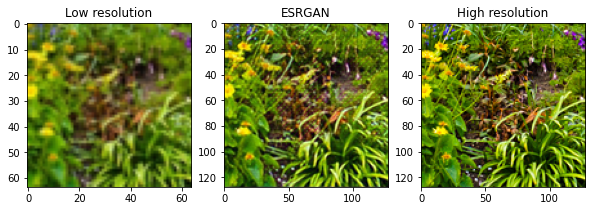

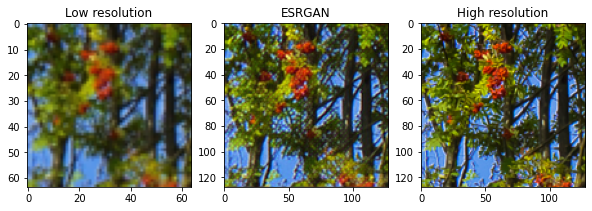

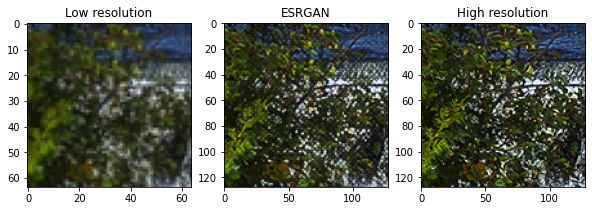

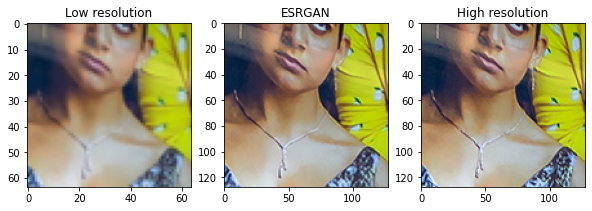

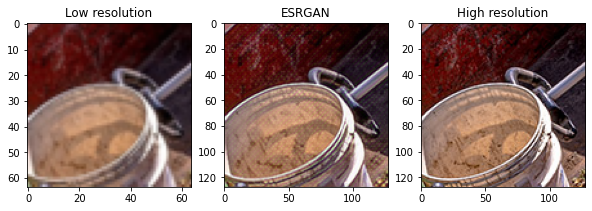

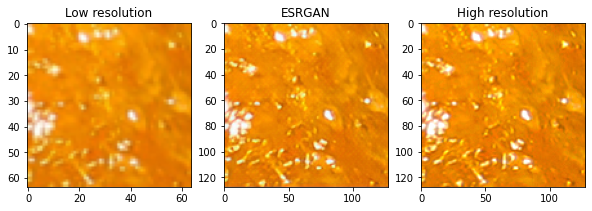

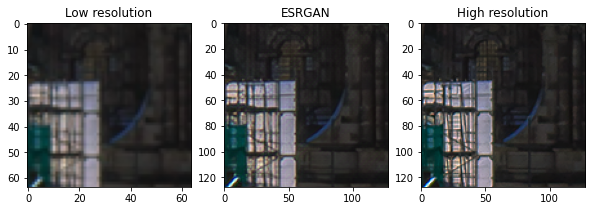

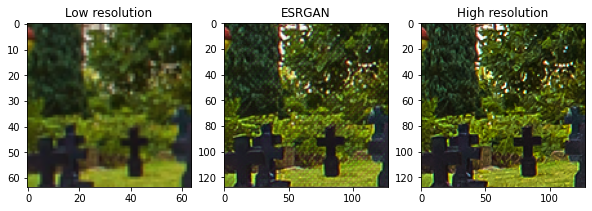

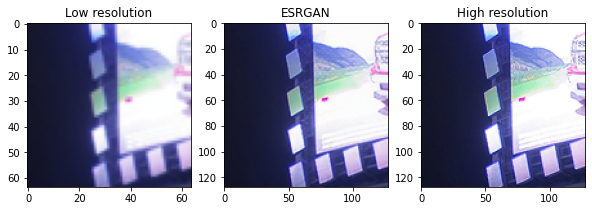

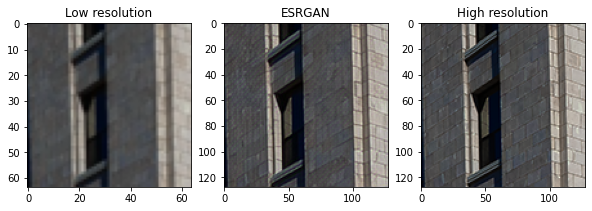

In [52]:
i = 0

Genmodel.cpu()
Genmodel.eval()
for hrimgs, lrimgs in tqdm(val_dataloader):
    if i == 10:
        break
    i += 1
    with torch.no_grad():
        outimg = Genmodel(lrimgs)

    lrimgs = lrimgs.squeeze().permute(1, 2, 0).numpy()
    outimg = outimg.squeeze().permute(1, 2, 0).numpy()
    hrimgs = hrimgs.squeeze().permute(1, 2, 0).numpy()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 8))
    ax1.imshow(np.clip(lrimgs, 0, 1))
    ax1.set_title("Low resolution")
    ax2.imshow(np.clip(outimg, 0, 1))
    ax2.set_title("ESRGAN")
    ax3.imshow(np.clip(hrimgs, 0, 1))
    ax3.set_title("High resolution");

In [34]:
test_df = pd.read_json("./test_data.json", orient="records")
test_df.head()

,id,name,url,image
0,DAAJ3U-A9005THSX,津好點斷擦拭紙/有架,https://a.ecimg.tw/items/DAAJ3UA9005THSX/00000...,000002_1477464802.jpg
1,DAAG23-A42593652,《百吉牌》袖珍面紙(10抽x36包),https://a.ecimg.tw/items/DAAG23A42593652/00000...,000002_1478122205.jpg
2,DAAG4D-A9008J3VU,【AQUA水】濕式衛生紙(10抽x4包x18串/箱),https://a.ecimg.tw/items/DAAG4DA9008J3VU/00000...,000002_1510208465.jpg
3,DAAG66-A9008XYMX,【AQUA水】濕式衛生紙(10抽x3+1包/串),https://a.ecimg.tw/items/DAAG66A9008XYMX/00000...,000002_1524015292.jpg
4,DAAG4M-A9006T8BL,大王製紙elleair超吸收強韌捲筒廚房紙巾(70抽/2入),https://a.ecimg.tw/items/DAAG4MA9006T8BL/00000...,000002_1478502402.jpg


In [35]:
class LRDataset(Dataset):
    def __init__(self, root, img_list, transform=None):
        super(LRDataset, self).__init__()
        self.root = root
        self.img_list = img_list
        self.transform = transform
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_list[idx])
        
        img = Image.open(img_path)
        img = img.convert("RGB")
        img = np.array(img)
        
        if self.transform is not None:
            lr_aug = self.transform(image=img)
            lr_img = lr_aug['image']
        
        return lr_img

In [36]:
test_transform = A.Compose([ToTensor()])

test_img_list = list(test_df['image'])
test_dataset = LRDataset(root="D:/project/super_resolution/test_data", img_list=test_img_list, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [2]:
Genmodel.cpu()
Genmodel.eval()
for lrimgs in tqdm(test_dataloader):
    with torch.no_grad():
        outimg = Genmodel(lrimgs)

    lrimgs = lrimgs.squeeze().permute(1, 2, 0).numpy()
    outimg = outimg.squeeze().permute(1, 2, 0).numpy()
    outimg = np.clip(outimg, 0, 1)*255
#     cv2.imwrite(f"./test_data_upscale/{i}.jpg", cv2.cvtColor(outimg, cv2.COLOR_RGB2BGR))
    
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
#     ax1.imshow(np.clip(lrimgs, 0, 1))
#     ax1.set_title("Origin")
#     ax2.imshow(np.clip(outimg, 0, 1))
#     ax2.set_title("Upscale image");